**Environment Setup**
==

**Importing the required Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, plot_precision_recall_curve

**Dataset Download**
==

In [2]:
raw_data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data', \
                       header=None, names=['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class'])

In [3]:
data = raw_data.copy()

**First five Records of the Data** *italicized text*

In [4]:
data.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


**Size of the Data**

In [5]:
print("Instances: {:}\nAttributes: {:}".format(data.shape[0], data.shape[1]))

Instances: 19020
Attributes: 11


**Statistical Info about the Data**

In [6]:
data.describe()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
count,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000
mean,53.250154,22.180966,2.825017,0.380327,0.214657,-4.331745,10.545545,0.249726,27.645707,193.818026
std,42.364855,18.346056,0.472599,0.182813,0.110511,59.206062,51.000118,20.827439,26.103621,74.731787
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600
25%,24.336000,11.863800,2.477100,0.235800,0.128475,-20.586550,-12.842775,-10.849375,5.547925,142.492250
50%,37.147700,17.139900,2.739600,0.354150,0.196500,4.013050,15.314100,0.666200,17.679500,191.851450
75%,70.122175,24.739475,3.101600,0.503700,0.285225,24.063700,35.837800,10.946425,45.883550,240.563825
max,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000


**Data Preprocessing and Feature Selection**
==

**Finding Missing Values** (if any)

In [7]:
data.isnull().values.any()

False

**Finding Redundant Attributes with HeatMap and Pairplots**

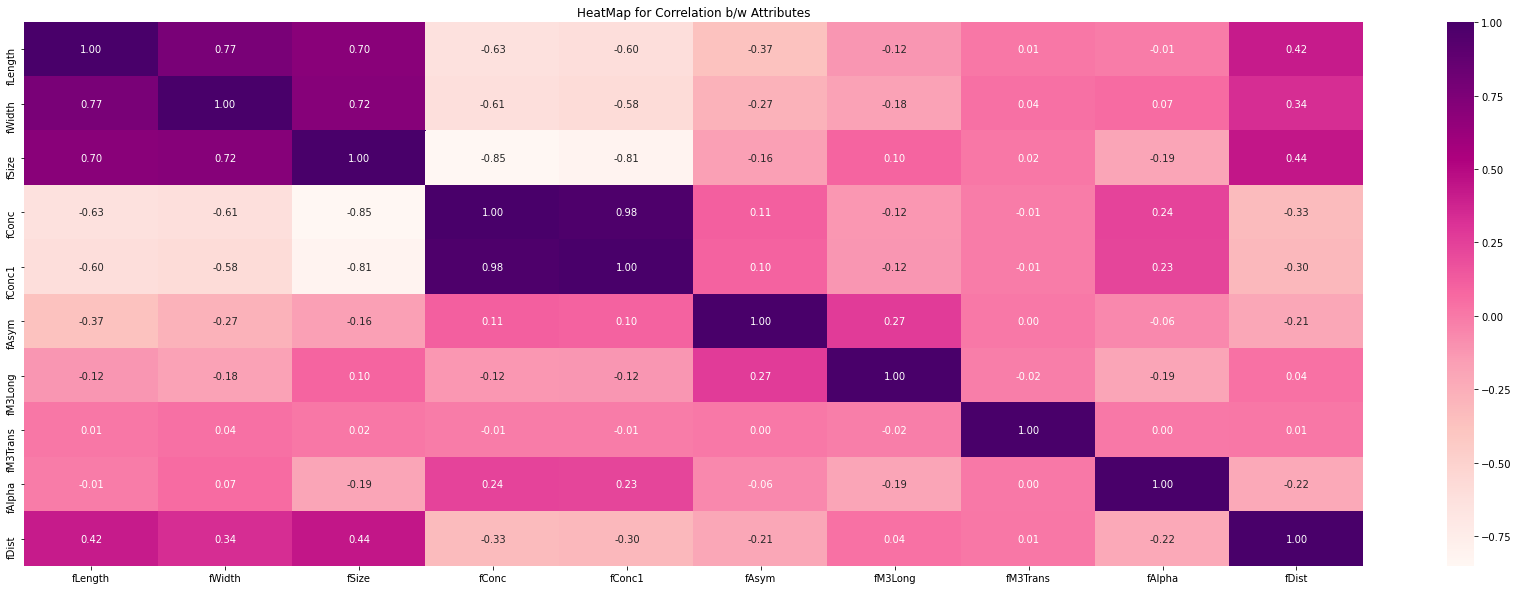

In [8]:
heatmap = sns.heatmap(data.corr(), cmap='RdPu', annot=True, fmt='.2f', ax=plt.subplots(figsize=(30, 10))[1])
heatmap.set(title='HeatMap for Correlation b/w Attributes');

PairPlots for Highly Correlated Attributes



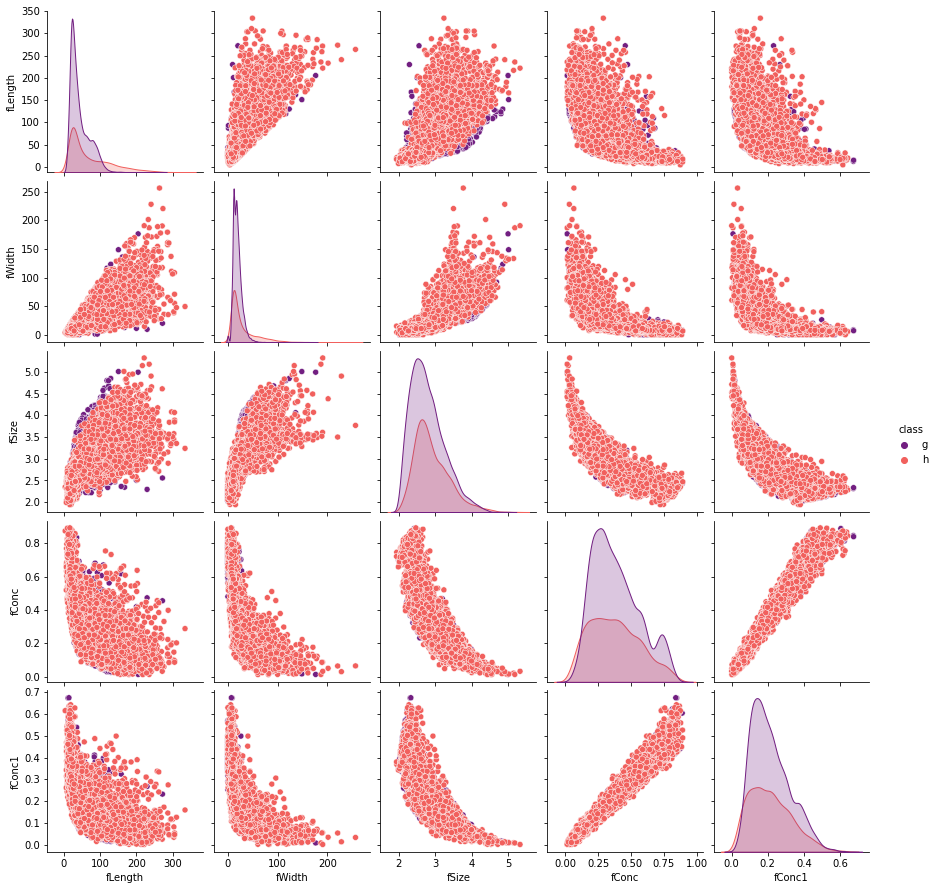

In [9]:
print('PairPlots for Highly Correlated Attributes\n')
pairplots = sns.pairplot(data=data.loc[:, ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'class']], palette='magma', hue='class')

**Feature Selection with Lasso Regularization**

In [10]:
x = data.drop(columns='class')   
y = data['class'].replace({'g': 0, 'h': 1})

In [11]:
reg = LassoCV()
reg.fit(x, y)
lasso = pd.DataFrame(x.columns.values, columns=['attribute'])
lasso.insert(1, 'coefficient', reg.coef_)

In [12]:
print('The attributes and their Lasso coefficient:')
lasso

The attributes and their Lasso coefficient:


,attribute,coefficient
0,fLength,0.003333
1,fWidth,-0.000687
2,fSize,-0.000000
3,fConc,0.000000
4,fConc1,0.000000
5,fAsym,-0.000118
6,fM3Long,-0.000696
7,fM3Trans,-0.000056
8,fAlpha,0.008443
9,fDist,0.000330


In [13]:
print('Lasso Regularization indicates us to drop {:} features and keep {:} features.'.format(lasso[lasso.coefficient == 0].shape[0], \
                                                                                             lasso[lasso.coefficient != 0].shape[0]))

Lasso Regularization indicates us to drop 3 features and keep 7 features.


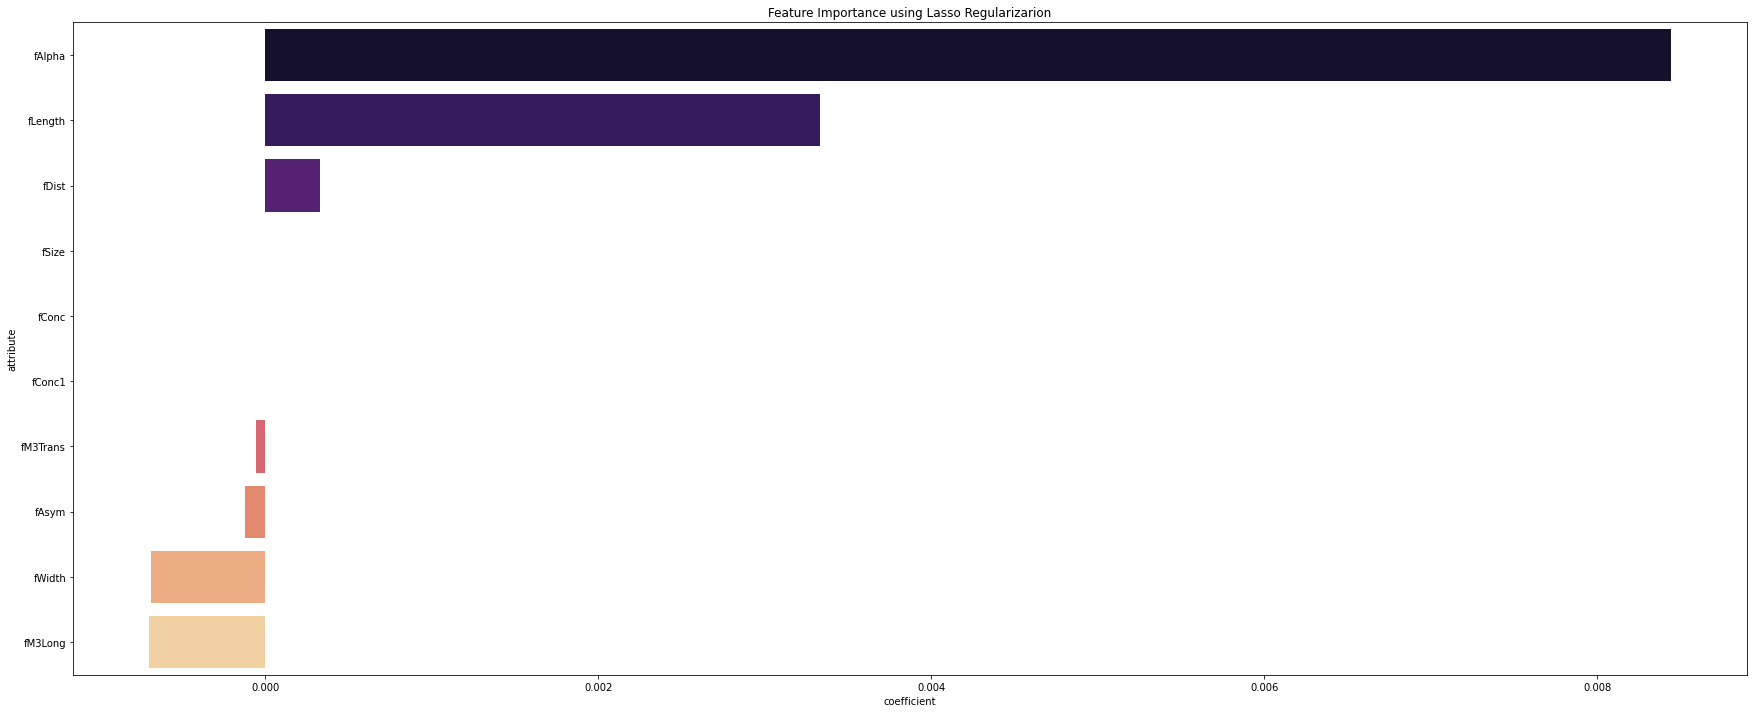

In [14]:
lasso = lasso.sort_values(by=['coefficient'], ascending=False)
barplot = sns.barplot(x='coefficient', y='attribute', data=lasso, palette='magma', ax=plt.subplots(figsize=(30, 12))[1])
barplot.set(title='Feature Importance using Lasso Regularizarion');

**Dropping the Unnecessary Attributes acc. to Lasso Regularization**

In [15]:
data = data.drop(columns=['fSize', 'fConc', 'fConc1'])

**Size of Data** (after dropping unnecessary features)

In [16]:
print("Instances: {:}\nAttributes: {:}".format(data.shape[0], data.shape[1]))

Instances: 19020
Attributes: 8


**Deleting Duplicate Records**

In [17]:
initial = data.shape[0]
data.drop_duplicates(subset=None, keep='first', inplace=True)
final = data.shape[0]
print('Deleting {:} records.'.format(initial - final))

Deleting 115 records.


**Size of Data** (after deleting duplicate records)

In [18]:
print("Instances: {:}\nAttributes: {:}".format(data.shape[0], data.shape[1]))

Instances: 18905
Attributes: 8


**Data Analysis**
==

**ViolinPlots to Analyse each Attribute**

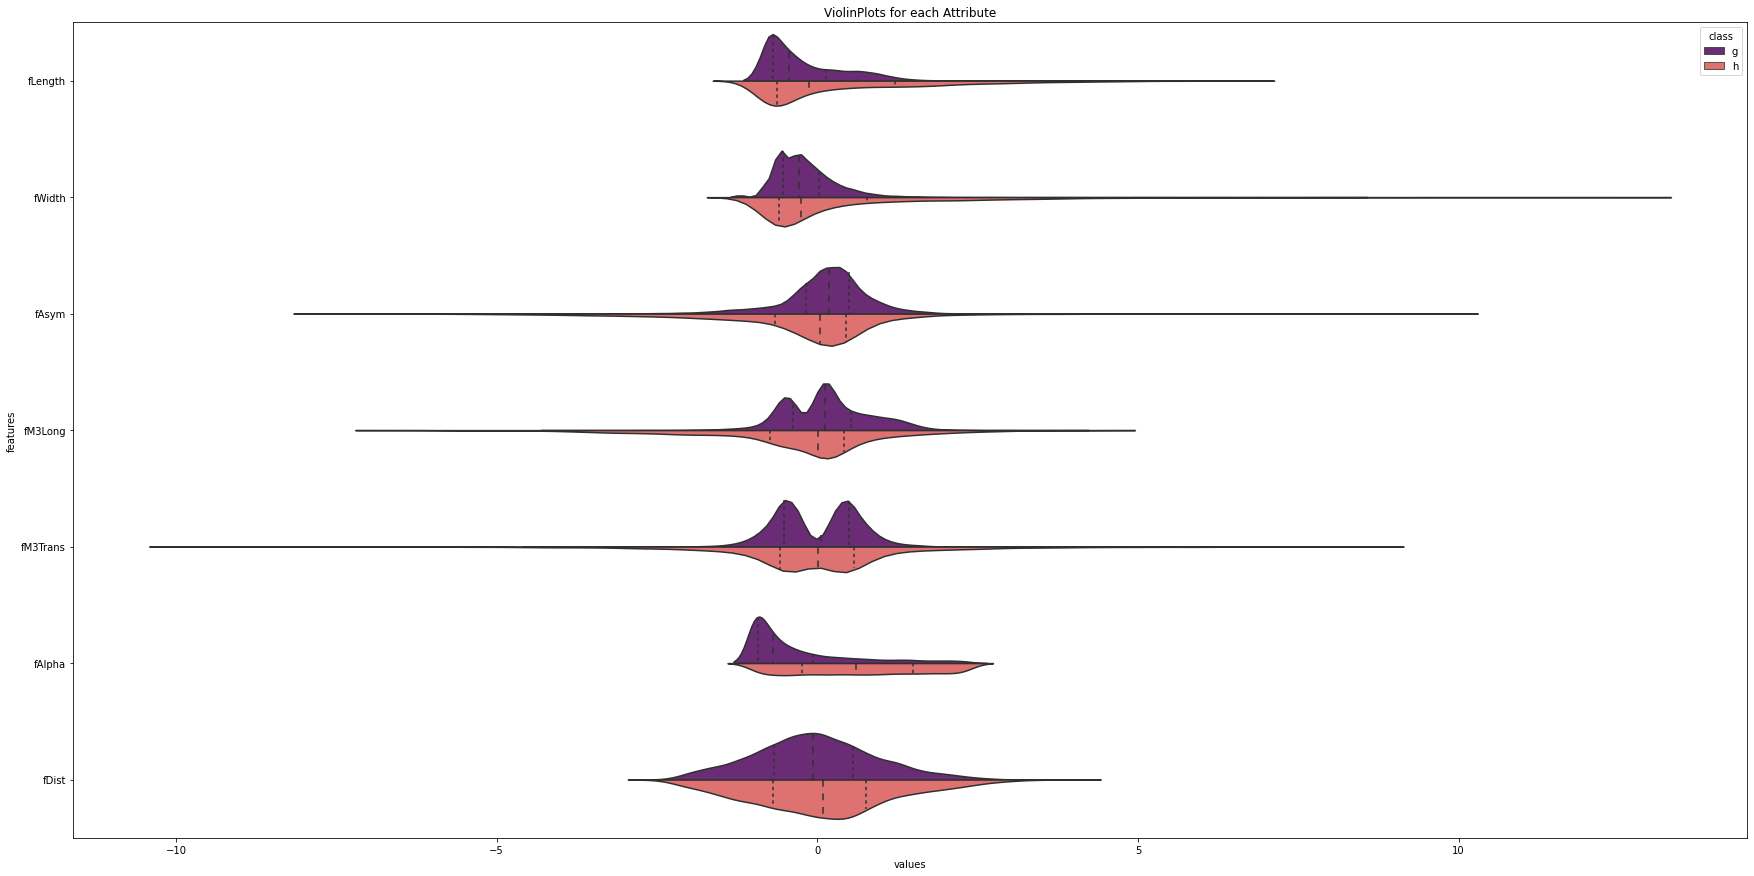

In [19]:
x_standarised = (data._get_numeric_data() - data.mean(numeric_only=True))/data.std(numeric_only=True)

data_melt = pd.concat([x_standarised, data['class']], axis=1)
data_melt = data_melt.melt(id_vars='class', var_name='features', value_name='values')
violinplot = sns.violinplot(x='values', y='features', hue='class', data=data_melt, inner='quartiles', split=True, \
                            palette='magma', ax=plt.subplots(figsize=(30, 15))[1], orient='h')
violinplot.set(title='ViolinPlots for each Attribute');

**A look at the Target Classes**

Count of gamma (signal): 12332
Count of hadron (background): 6573



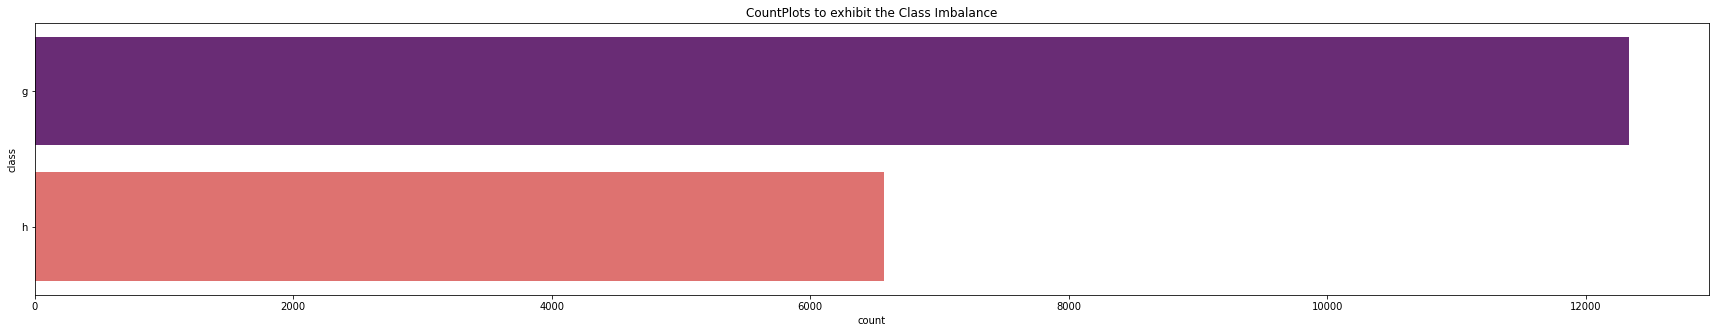

In [20]:
g, h = data['class'].value_counts()
print('Count of gamma (signal): {:}\nCount of hadron (background): {:}\n'.format(g, h))
countplot = sns.countplot(y='class', data=data, palette='magma', ax=plt.subplots(figsize=(30, 5))[1])
countplot.set(title='CountPlots to exhibit the Class Imbalance');

**Data Scaling** (required for SVM)

In [21]:
x_standarized = (data._get_numeric_data() - data.mean(numeric_only=True))/data.std(numeric_only=True)

**Encoding Categorical Data**

In [22]:
x = data.drop(columns='class')   
y = data['class'].replace({'g': 0, 'h': 1})

**Classification and Model Evaluation**
==

**Data Splitting**

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)
x_standarized_train, x_standarized_test, y_standarized_train, y_standarized_test = train_test_split(x_standarized, y, test_size=0.3, \
                                                                                                    random_state=0, stratify=y)
print("Number of training examples: {:}\nNumber of testing examples: {:}".format(len(x_train), len(x_test)))

Number of training examples: 13233
Number of testing examples: 5672


**Classification using Support Vector Machine (SVM)**

Support Vector Machine
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min finished



Accuracy: 0.8295133991537377
F1 Score: 0.8693772794812914
Average Precision: 0.8523467263263728



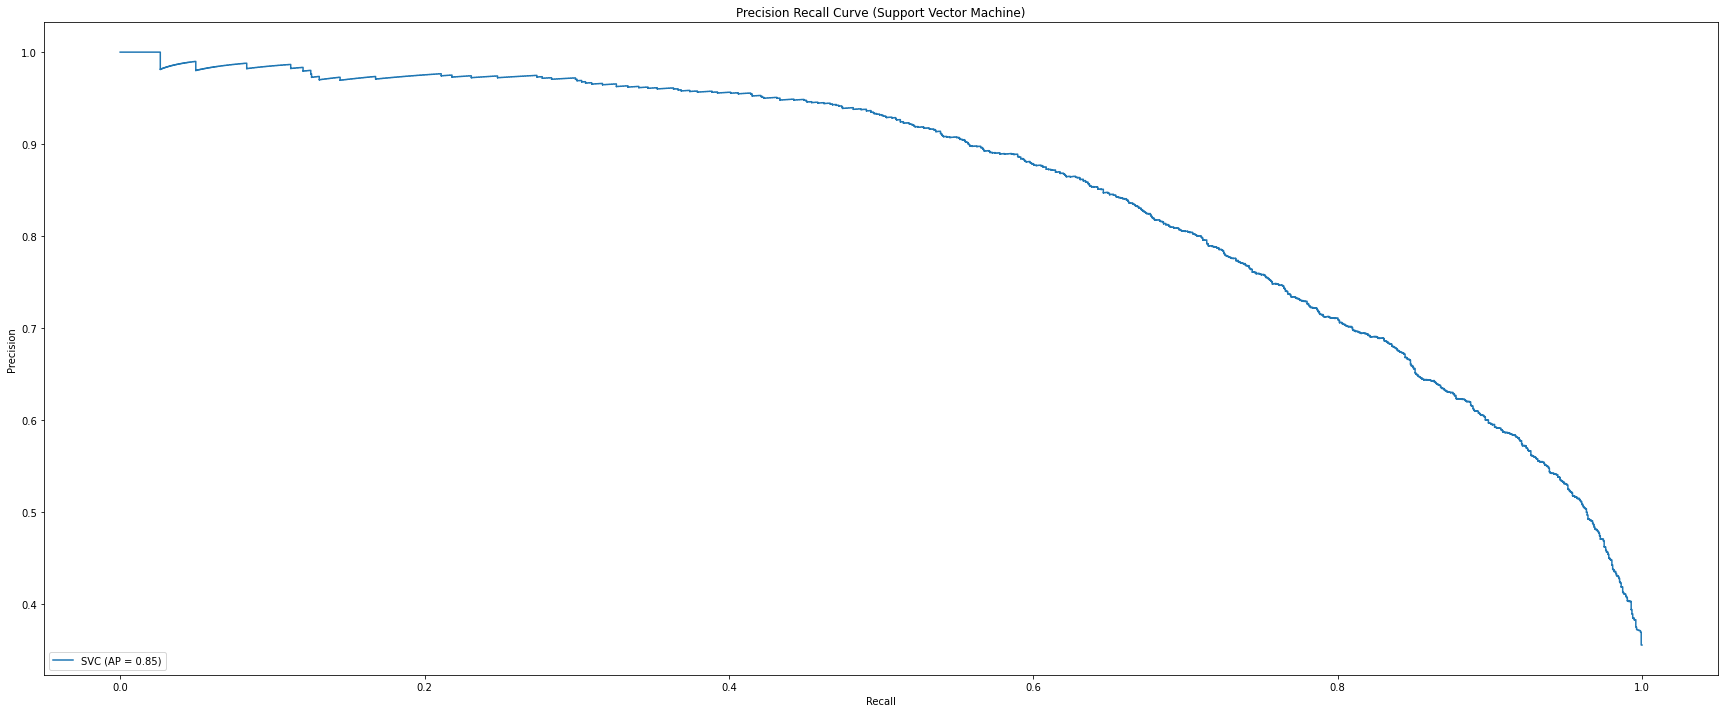

In [24]:
print('Support Vector Machine')

param_grid = {'C': [1, 10], 'gamma': [0.01, 0.1]}

clf = SVC(kernel='rbf', class_weight='balanced')
model = GridSearchCV(clf, param_grid, scoring='f1', n_jobs=-1, cv=5, verbose=1)
model.fit(x_standarized_train, np.ravel(y_standarized_train))

svm_model = model.best_estimator_

y_standarized_pred = svm_model.predict(x_standarized_test)

accuracy = accuracy_score(y_standarized_test, y_standarized_pred)
f1 = f1_score(y_standarized_test, y_standarized_pred, pos_label=0, average='binary')
average_precision = average_precision_score(y_standarized_test, svm_model.decision_function(x_standarized_test))
print('\nAccuracy: {:}\nF1 Score: {:}\nAverage Precision: {:}\n'.format(accuracy, f1, average_precision))

svm_prc = plot_precision_recall_curve(svm_model, x_standarized_test, y_standarized_test, ax=plt.subplots(figsize=(30, 12))[1])
svm_prc.ax_.set(title='Precision Recall Curve (Support Vector Machine)');

**Classifcation using Decision Tree Classifier**

In [25]:
x_raw = raw_data.drop(columns='class')
y_raw = raw_data['class'].replace({'g': 0, 'h': 1})
x_raw_train, x_raw_test, y_raw_train, y_raw_test=train_test_split(x_raw, y_raw, test_size=0.3, random_state=0, stratify=y_raw)

Decision Tree Classifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.0s finished



Accuracy: 0.8315807921486155
F1 Score: 0.8665092373940826
Average Precision: 0.8640667390339235



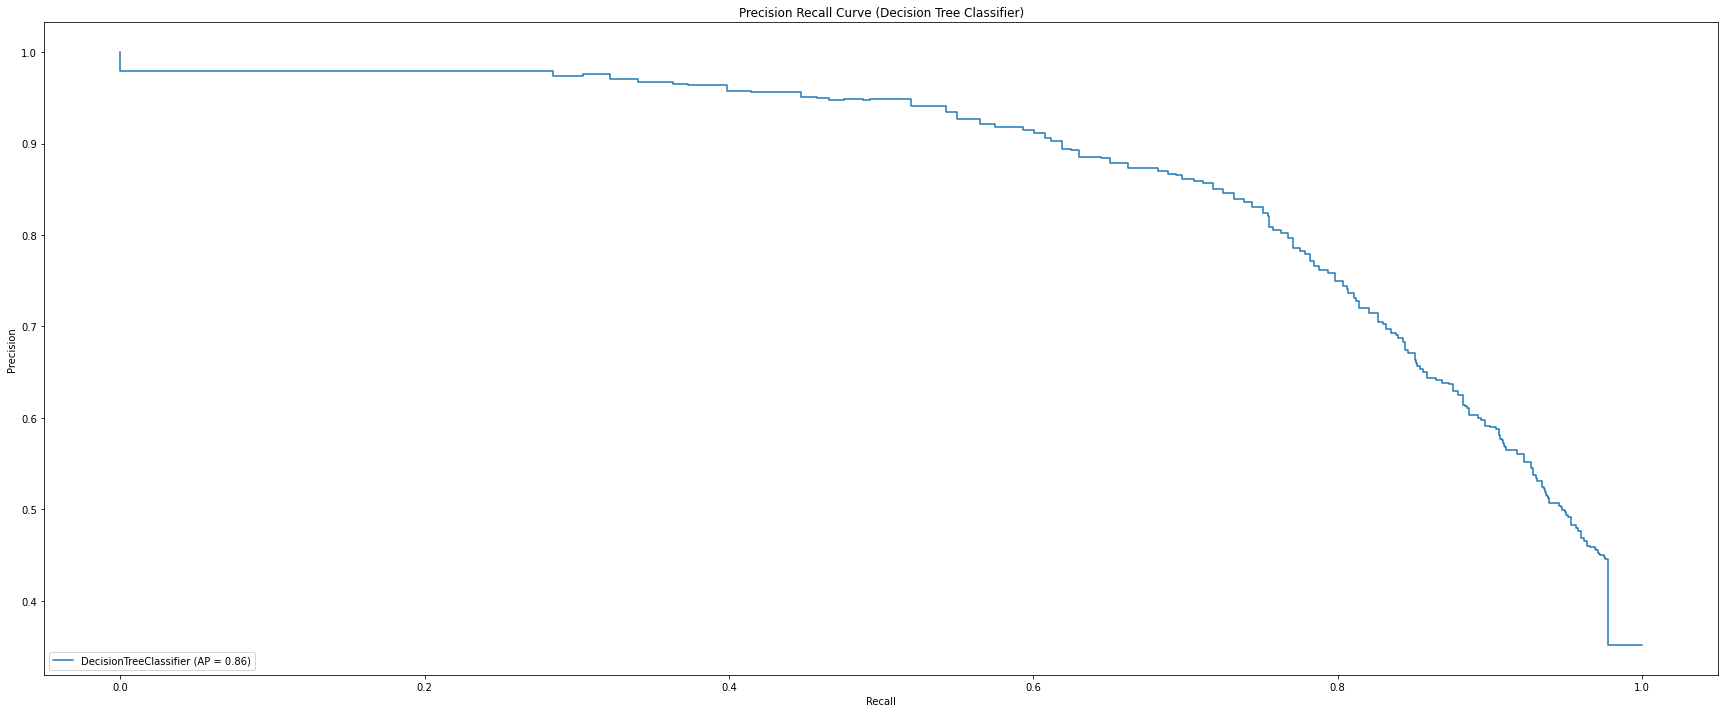

In [26]:
print('Decision Tree Classifier')

param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 100, 2), 'min_samples_split' : range(2, 200, 10), \
              'min_samples_leaf': range(1, 100, 10)}

clf_tree = DecisionTreeClassifier(class_weight='balanced')
model = RandomizedSearchCV(clf_tree, param_grid, scoring='f1', n_jobs=-1, cv=5, verbose=1)
model.fit(x_raw_train, np.ravel(y_raw_train))

dt_model = model.best_estimator_

y_raw_pred = dt_model.predict(x_raw_test)

accuracy = accuracy_score(y_raw_test, y_raw_pred)
f1 = f1_score(y_raw_test, y_raw_pred, pos_label=0, average='binary')
average_precision = average_precision_score(y_raw_test, dt_model.predict_proba(x_raw_test)[:, 1])
print('\nAccuracy: {:}\nF1 Score: {:}\nAverage Precision: {:}\n'.format(accuracy, f1, average_precision))

dt_prc = plot_precision_recall_curve(dt_model, x_raw_test, y_raw_test, ax=plt.subplots(figsize=(30, 12))[1])
dt_prc.ax_.set(title='Precision Recall Curve (Decision Tree Classifier)');

**Classification using Random Forest Classifier**

Random Forest Classifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.3min finished



Accuracy: 0.8838065194532071
F1 Score: 0.9127057274522712
Average Precision: 0.9106250629053892



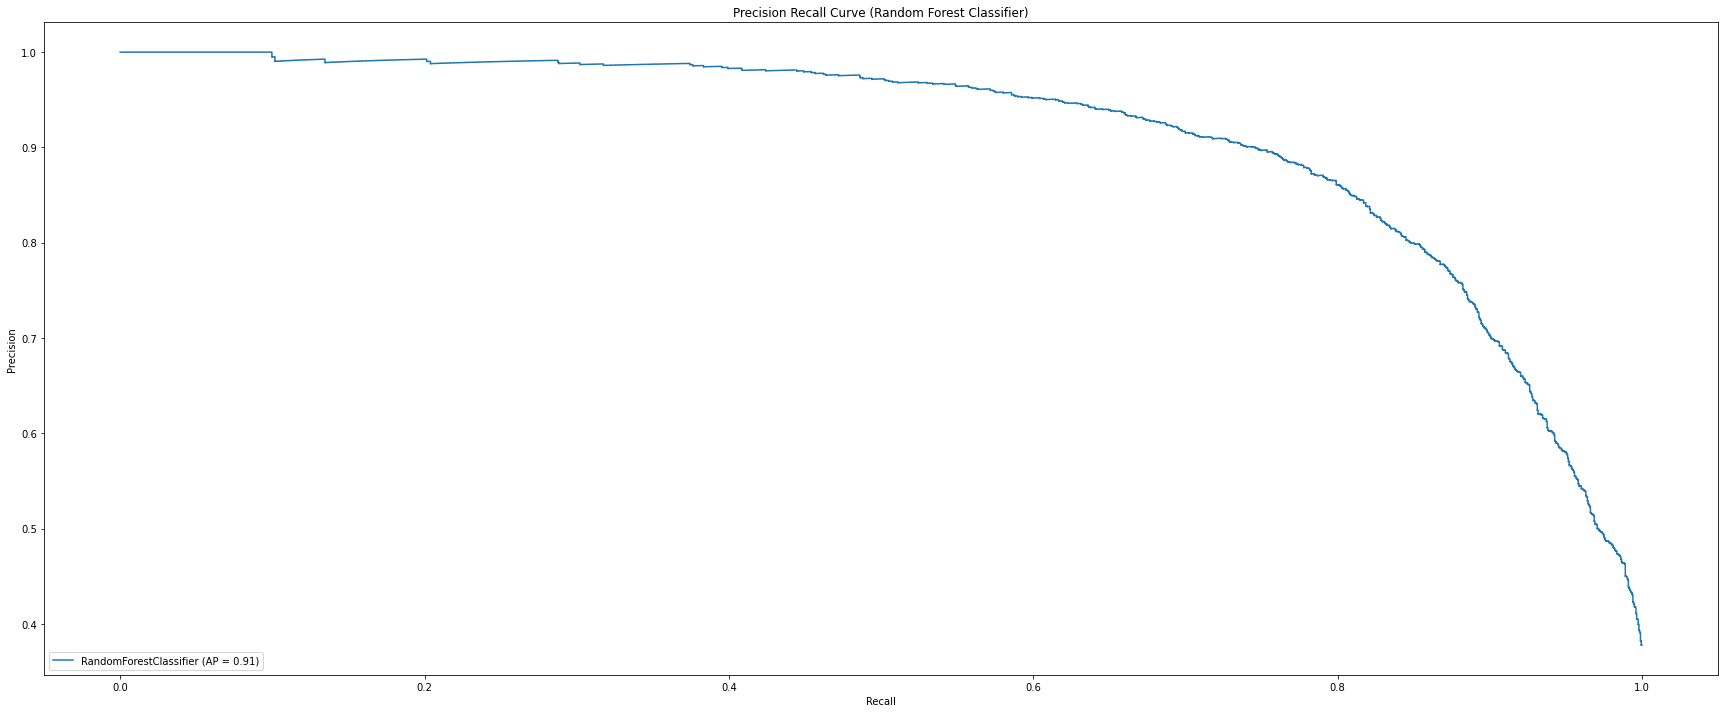

In [27]:
print('Random Forest Classifier')

param_grid = {'n_estimators': range(100, 1000, 100), 'criterion': ['gini', 'entropy'], 'max_depth': range(5, 15, 2), \
              'max_features': ['sqrt', 'None']}

clf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42, class_weight='balanced')
model = RandomizedSearchCV(clf, param_grid, scoring='f1', n_jobs=-1, cv=5, verbose=1)
model.fit(x_raw_train, np.ravel(y_raw_train))

rf_model = model.best_estimator_

y_raw_pred = rf_model.predict(x_raw_test)

accuracy = accuracy_score(y_raw_test, y_raw_pred)
f1 = f1_score(y_raw_test, y_raw_pred, pos_label=0, average='binary')
average_precision = average_precision_score(y_raw_test, rf_model.predict_proba(x_raw_test)[:,1])
print('\nAccuracy: {:}\nF1 Score: {:}\nAverage Precision: {:}\n'.format(accuracy, f1, average_precision))

rf_prc = plot_precision_recall_curve(rf_model, x_raw_test, y_raw_test, ax=plt.subplots(figsize=(30, 12))[1])
rf_prc.ax_.set(title='Precision Recall Curve (Random Forest Classifier)');